In [1]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb


# Read in dataset
df = pd.read_csv("heloc_dataset_v1.csv")
df.head(3)

# Remove rows with missing values
df = df[~df.isin([-9]).any(axis=1)]

# Calculate group means for numerical columns where -7 needs to be replaced
group_means = df.replace(-7, np.nan).groupby('RiskPerformance').mean()

# Function to impute -7 with group means based on Risk_Performance
def impute_with_group_mean(row):
    for col in df.columns:
        # Skip non-numerical columns (like 'Risk_Performance')
        if col == 'RiskPerformance' or not np.issubdtype(df[col].dtype, np.number):
            continue
        # Replace -7 with the corresponding group's mean
        if row[col] == -7:
            row[col] = group_means.loc[row['RiskPerformance'], col]
    return row

# Apply the function row by row
df = df.apply(impute_with_group_mean, axis=1)



# Check and remove duplicate rows
duplicates = df.duplicated()
num_duplicates = duplicates.sum()
#print(f"Number of duplicate rows: {num_duplicates}")

duplicate_rows = df[duplicates]
#print("Duplicate rows:\n", duplicate_rows)

df = df.drop_duplicates()


label_encoder = LabelEncoder()

# Separate features and target variable
X = df.drop(columns=['RiskPerformance'])
y = label_encoder.fit_transform(df['RiskPerformance'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Lasso regression with cross-validation
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract feature importance
lasso_importance = pd.Series(lasso.coef_, index=X.columns)
important_features = lasso_importance[lasso_importance != 0].sort_values(ascending=False)

# Print the top 10 most important features
top_n = 24
print(f"Top {top_n} Important Features Based on Lasso Regression:")
print(important_features.head(top_n))

# Class Imbalance
counts = df["RiskPerformance"].value_counts()
print("Counts of 'Bad' vs 'Good':")
print(counts)

# Step 2: Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# New class distribution
print("Resampled class distribution:", Counter(y_resampled))

Top 24 Important Features Based on Lasso Regression:
ExternalRiskEstimate                  0.119544
NumInqLast6Mexcl7days                 0.098126
MSinceMostRecentDelq                  0.075133
NumSatisfactoryTrades                 0.062653
AverageMInFile                        0.047528
MaxDelqEver                           0.037992
MSinceMostRecentInqexcl7days          0.025538
NumInstallTradesWBalance              0.018091
NumBank2NatlTradesWHighUtilization    0.016210
MSinceOldestTradeOpen                 0.012396
PercentTradesNeverDelq                0.012296
NumTrades60Ever2DerogPubRec           0.005597
PercentTradesWBalance                 0.004255
NumTotalTrades                       -0.000416
NumTrades90Ever2DerogPubRec          -0.001992
NetFractionInstallBurden             -0.004670
NumTradesOpeninLast12M               -0.008103
MSinceMostRecentTradeOpen            -0.008568
MaxDelq2PublicRecLast12M             -0.016938
PercentInstallTrades                 -0.033737
NumRevo

In [3]:
rows=df.shape[0]
rows

9860

### Logistic Regression Model

In [4]:
#Train logistic regression model
log_reg=LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_resampled, y_resampled)

# Make predictions
y_pred = log_reg.predict(X_test)



In [5]:
# Step 9: Model Evaluation for logistic regression model
log_accuracy = accuracy_score(y_test, y_pred)
log_precision = precision_score(y_test, y_pred)
log_recall = recall_score(y_test, y_pred)
log_f1 = f1_score(y_test, y_pred)

print("🔍 Model Performance Metrics:")
print(f"Accuracy: {log_accuracy:.4f}")
print(f"Precision: {log_precision:.4f}")
print(f"Recall: {log_recall:.4f}")
print(f"F1 Score: {log_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


🔍 Model Performance Metrics:
Accuracy: 0.7383
Precision: 0.7156
Recall: 0.7476
F1 Score: 0.7313

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.75      1033
           1       0.72      0.75      0.73       939

    accuracy                           0.74      1972
   macro avg       0.74      0.74      0.74      1972
weighted avg       0.74      0.74      0.74      1972



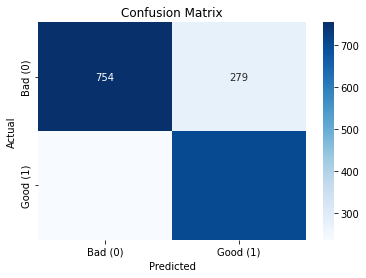

In [6]:
# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Random Forest Model

In [7]:

#Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model.fit(X_resampled, y_resampled)

#Make Predictions
y_pred = rf_model.predict(X_test)

#Model Evaluation
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)

# Printing output 
print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Random Forest Model Performance:
Accuracy: 0.8808
Precision: 0.8929
Recall: 0.8520
F1 Score: 0.8719

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      1033
           1       0.89      0.85      0.87       939

    accuracy                           0.88      1972
   macro avg       0.88      0.88      0.88      1972
weighted avg       0.88      0.88      0.88      1972



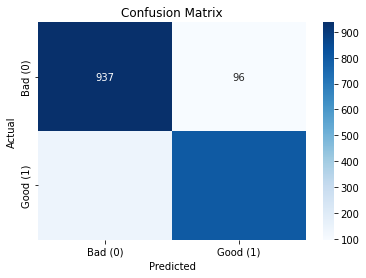

In [8]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Random Forest Model + Random Search Grid for imoroving the model by hypertuning Parameter 

In [27]:


# Define Random Search Grid
random_grid = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': np.arange(10, 50, 5),
    'min_samples_split': np.arange(2, 10, 2),
    'min_samples_leaf': np.arange(1, 5, 1),
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(rf_model, param_distributions=random_grid, 
                                   n_iter=20, cv=5, scoring='f1', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_resampled, y_resampled)

# Best Model
best_rf_model_random = random_search.best_estimator_

# Predictions on Test Set
y_pred_rf_random = best_rf_model_random.predict(X_test)

# Evaluate Performance
accuracy_random = accuracy_score(y_test, y_pred_rf_random)
precision_random = precision_score(y_test, y_pred_rf_random)
recall_random = recall_score(y_test, y_pred_rf_random)
f1_random = f1_score(y_test, y_pred_rf_random)

print("Best Hyperparameters (via Random Search):", random_search.best_params_)
print("Tuned Random Forest Performance (Randomized Search):")
print(f"Accuracy: {accuracy_random:.4f}")
print(f"Precision: {precision_random:.4f}")
print(f"Recall: {recall_random:.4f}")
print(f"F1 Score: {f1_random:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters (via Random Search): {'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced'}
Tuned Random Forest Performance (Randomized Search):
Accuracy: 0.8798
Precision: 0.8944
Recall: 0.8477
F1 Score: 0.8704


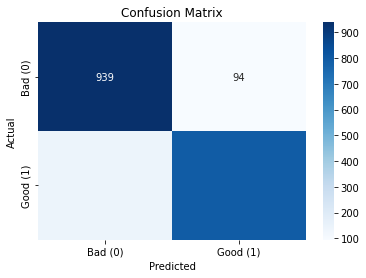

In [28]:
#Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred_rf_random)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/site-packages/xgboost/data.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.10/site-packages/xgboost/data.py:300: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


XGBoost Model Performance:
Accuracy: 0.8783
Precision: 0.8853
Recall: 0.8552
F1 Score: 0.8700

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89      1033
           1       0.89      0.86      0.87       939

    accuracy                           0.88      1972
   macro avg       0.88      0.88      0.88      1972
weighted avg       0.88      0.88      0.88      1972



/usr/local/lib/python3.10/site-packages/xgboost/data.py:298: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/usr/local/lib/python3.10/site-packages/xgboost/data.py:300: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:


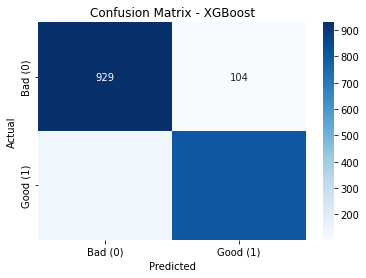

/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


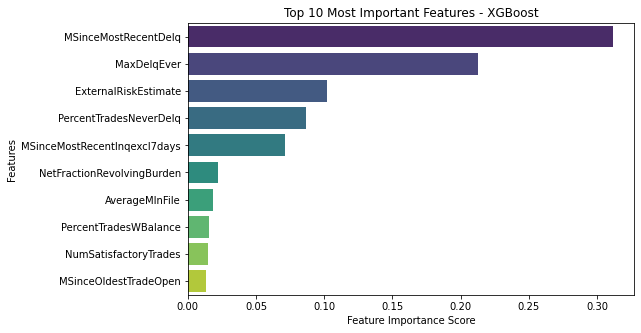

In [29]:

# Train XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # Adjust this for imbalanced data
    random_state=42
)

xgb_model.fit(X_resampled, y_resampled)

# Make Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Model Evaluation
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Model Performance:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

#Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=["Bad (0)", "Good (1)"], yticklabels=["Bad (0)", "Good (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

#Feature Importance Visualization
xgb_feature_importance = pd.Series(xgb_model.feature_importances_, index=df.drop(columns=['RiskPerformance']).columns)
top_features_xgb = xgb_feature_importance.sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features_xgb.values, y=top_features_xgb.index, palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Most Important Features - XGBoost")
plt.show()

In [30]:
import pandas as pd

# Assuming these values were calculated in your script
model_comparison = {
    "Model": ["XGBoost", "Random Forest (Tuned)", "Random Forest", "Logistic Regression"],
    "Accuracy": [accuracy_xgb, accuracy_random, rf_accuracy, log_accuracy],
    "Precision": [precision_xgb, precision_random, rf_precision, log_precision],
    "Recall": [recall_xgb, recall_random, rf_recall, log_recall],
    "F1-Score": [f1_xgb, f1_random, rf_f1, log_f1]
}

# Convert to DataFrame
comparison_df = pd.DataFrame(model_comparison)
comparison_df




,Model,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.878296,0.885336,0.855165,0.869989
1,Random Forest (Tuned),0.879817,0.894382,0.847710,0.870421
2,Random Forest,0.880832,0.892857,0.851970,0.871935
3,Logistic Regression,0.738337,0.715596,0.747604,0.731250


[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=8, n_estimators=600; total time=   4.0s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced_subsample, max_depth=35, max_features=sqrt, min_samples_leaf=1, min_samples_split=8, n_estimators=200; total time=   1.6s
[CV] END class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=8, n_estimators=600; total time=   4.7s
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=800; total time=   5.5s
[CV] END class_weight=balanced, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=8, n_estimators=800; total time=   5.5s
[CV] END class_weight=balanced_subsample, max_depth=45, max_features=sqrt, min_samples_leaf=3, min_samples_split